In [1]:
# ================================
# Full Simulation Loop Script
# ================================
import os
import random
import numpy as np
import pandas as pd
import warnings
from copy import deepcopy
from pathlib import Path

# plotting imports not needed for batch runs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

# ------------------------------------------------
# Reproducibility
# ------------------------------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)

# ================================
# Load and prepare dataset
# This is a random subset of real data with some rounding of features to deidentify individuals
# treatment is the radiation dose in mSv
# ================================
fullSet_sampled_base = pd.read_csv("sampled_data_rounded.csv")


# ================================
# Utility functions
# ================================
class PolynomialFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2):
        self.degree = degree
        self.poly = PolynomialFeatures(degree=degree, include_bias=False)
        self._is_fitted = False

    def fit(self, X, y=None):
        X = np.asarray(X).reshape(-1, 1)
        self.poly.fit(X)
        self._is_fitted = True
        return self

    def transform(self, X):
        X = np.asarray(X).reshape(-1, 1)
        return self.poly.transform(X)


class IgnoreSampleWeightWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator
        self.model_ = None

    def fit(self, X, y, sample_weight=None):
        self.model_ = clone(self.base_estimator)
        self.model_.fit(X, y)  # ignore sample_weight
        return self

    def predict(self, X):
        return self.model_.predict(X)


def _ensure_2d_numeric_matrix(X):
    if isinstance(X, pd.DataFrame):
        Xnum = pd.get_dummies(X, drop_first=False)
        return Xnum.values, Xnum.columns.tolist()
    elif isinstance(X, pd.Series):
        return X.values.reshape(-1, 1), [X.name]
    else:
        arr = np.asarray(X)
        if arr.ndim == 1:
            arr = arr.reshape(-1, 1)
        return arr, None


def fit_censoring_model(X, T, times, events, intercept, random_state=42,
                        n_estimators=500, min_samples_leaf=10):
    """Fit RandomSurvivalForest for censoring."""
    X_vals, _ = _ensure_2d_numeric_matrix(X)
    T_arr = T.values.reshape(-1, 1) if isinstance(T, pd.DataFrame) else np.asarray(T).reshape(-1, 1)
    X_with_T = np.column_stack([X_vals, T_arr])
    y_censor = Surv.from_arrays(event=(1 - events).astype(bool), time=times)

    rsf = RandomSurvivalForest(
        n_estimators=n_estimators,
        min_samples_split=10,
        min_samples_leaf=min_samples_leaf,
        max_features="sqrt",
        n_jobs=-1,
        random_state=random_state,
        verbose=0
    )
    rsf.fit(X_with_T, y_censor)
    return rsf, np.max(times)


def calculate_ipcw_weights(X, T, times, events, censoring_model,
                           rmst_tau, max_train_time=None, min_prob=0.05,
                           trim_max_weight=None, normalize=True):
    X_vals, _ = _ensure_2d_numeric_matrix(X)
    T_arr = T.values.reshape(-1, 1) if isinstance(T, pd.DataFrame) else np.asarray(T).reshape(-1, 1)
    X_with_T = np.column_stack([X_vals, T_arr])

    t_star = np.minimum(times, rmst_tau)
    t_eval = np.minimum(t_star, max_train_time) if max_train_time is not None else t_star

    surv_funcs = censoring_model.predict_survival_function(X_with_T)
    S_c = np.array([fn(t) for fn, t in zip(surv_funcs, t_eval)])
    S_c = np.clip(S_c, min_prob, None)

    observed = ((events == 1) | (times >= rmst_tau)).astype(float)
    weights = observed / S_c
    weights = np.nan_to_num(weights, nan=0.0, posinf=np.nanmax(weights[np.isfinite(weights)]))

    if trim_max_weight is not None:
        weights = np.minimum(weights, trim_max_weight)
    if normalize:
        n = len(weights)
        total = np.sum(weights)
        if total > 0:
            weights = weights * (n / total)
    return weights


def create_causal_forest_for_rmst(featurizer_degree=2,
                                  treatment_model_ignore_weights=True,
                                  cv=5, mc_iters=5, n_estimators=500,
                                  random_state=42):
    outcome_model = RandomForestRegressor(n_estimators=500, min_samples_leaf=10,
                                          max_depth=5, random_state=random_state, n_jobs=-1)
    base_t = RandomForestRegressor(n_estimators=500, min_samples_leaf=10,
                                   max_depth=5, random_state=random_state, n_jobs=-1)
    treatment_model = IgnoreSampleWeightWrapper(base_t) if treatment_model_ignore_weights else base_t
    featurizer = PolynomialFeaturizer(degree=featurizer_degree)

    return CausalForestDML(
        model_y=outcome_model,
        model_t=treatment_model,
        treatment_featurizer=featurizer,
        cv=cv, mc_iters=mc_iters,
        n_estimators=n_estimators,
        random_state=random_state
    )


def fit_rmst_cdml(X_train, t_train, outcomes_train, rmst_tau,
                  random_state=42, cdml_params=None):
    if cdml_params is None:
        cdml_params = dict(cv=5, mc_iters=5, n_estimators=500)

    times = outcomes_train["time"].values
    events = outcomes_train["event"].values

    censor_model, max_train_time = fit_censoring_model(X_train, t_train, times, events, intercept=0,
                                                       random_state=random_state)
    weights = calculate_ipcw_weights(X_train, t_train, times, events,
                                     censor_model, rmst_tau, max_train_time,
                                     min_prob=0.05, trim_max_weight=20, normalize=True)
    Y_rmst = np.minimum(times, rmst_tau)

    cdml = create_causal_forest_for_rmst(random_state=random_state, **cdml_params)
    X_values, _ = _ensure_2d_numeric_matrix(X_train)
    T_values = t_train.values.reshape(-1, 1)
    cdml.fit(Y=Y_rmst, T=T_values, X=X_values, sample_weight=weights, cache_values=True)
    return cdml, censor_model, weights


# ================================
# Simulation loop
# ================================
fake_effect_vals = [-0.08, -0.06, -0.04, -0.02, 0, 0.02, 0.04, 0.06, 0.08]
censor_intercepts = [-1, -0.5, 0, 0.5, 1]
rmst_tau = 30
results = []

for feff in fake_effect_vals:
    for cint in censor_intercepts:
        print(f"\n=== Running simulation: fake_effect={feff}, intercept={cint} ===")

        # Copy base data
        df = deepcopy(fullSet_sampled_base)

        # simulate survival times
        baseline_val = 30.
        df["time"] = np.maximum(0.01, (
            baseline_val / (1 + 5.*(df["Age_at_termination"]/100.)**4
                            + 2.5*((df["Year_of_hire"]-1900.)/100.)**2)
            + feff * df["treatment"]
            + np.random.normal(0, 0.05, size=df.shape[0])
        ))

        # simulate censoring
        logits = cint + 3. * df["Age_at_termination"]/100.
        censor_probs = np.clip(np.exp(logits) / (1+np.exp(logits)), 0.01, 0.99)
        is_event = np.random.binomial(1, 1 - censor_probs)
        df["event"] = is_event
        censored_prop = 1 - df["event"].mean()

        # split data
        X = df.drop(columns=["treatment", "time", "event"])
        T = df["treatment"]
        outcomes = df[["time", "event"]]
        X_train, X_test, T_train, T_test, out_train, out_test = train_test_split(
            X, T, outcomes, train_size=0.7, random_state=42
        )

        # fit model
        model, censor_model, weights = fit_rmst_cdml(X_train, T_train, out_train,
                                                     rmst_tau=rmst_tau,
                                                     random_state=42,
                                                     cdml_params={'cv': 5, 'mc_iters': 5, 'n_estimators': 200})

        
        # -----------------------------------------
        # Extract summary for CausalForestDML model
        # -----------------------------------------

        # Get CATE predictions on training data
        effects = model.effect(X_train)  # shape: (n_samples,) since treatment is continuous & univariate

        # Confidence intervals
        ci_lower, ci_upper = model.effect_interval(X_train)

        # Build summary dataframe
        summary_df = pd.DataFrame({
            "mean": [effects.mean()],
            "ci_mean_lower": [ci_lower.mean()],
            "ci_mean_upper": [ci_upper.mean()]
        }, index=["feat(T)0"])

        # Pull row as dict
        row_T0 = summary_df.loc["feat(T)0"].to_dict()

        # Append results (no feat(T)1 for continuous single treatment)
        results.append({
            "fake_effect_val": feff,
            "fake_effect_val_2": 0.0,
            "censor_intercept": cint,
            "censored_prop": censored_prop,
            "feat(T)0_mean": row_T0.get("mean", np.nan),
            "feat(T)0_ci_lower": row_T0.get("ci_mean_lower", np.nan),
            "feat(T)0_ci_upper": row_T0.get("ci_mean_upper", np.nan)
        })

        
        

        

# ================================
# Save results
# ================================
results_df = pd.DataFrame(results)
results_df.to_csv("simulation_results.csv", index=False)
print("\n✅ Simulation complete. Results saved to simulation_results.csv")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



=== Running simulation: fake_effect=-0.08, intercept=-1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.08, intercept=-0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.08, intercept=0 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.08, intercept=0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.08, intercept=1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.06, intercept=-1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.06, intercept=-0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.06, intercept=0 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.06, intercept=0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.06, intercept=1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.04, intercept=-1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.04, intercept=-0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.04, intercept=0 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.04, intercept=0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.04, intercept=1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.02, intercept=-1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.02, intercept=-0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.02, intercept=0 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.02, intercept=0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=-0.02, intercept=1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0, intercept=-1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0, intercept=-0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0, intercept=0 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0, intercept=0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0, intercept=1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.02, intercept=-1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.02, intercept=-0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.02, intercept=0 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.02, intercept=0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.02, intercept=1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.04, intercept=-1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.04, intercept=-0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.04, intercept=0 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.04, intercept=0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.04, intercept=1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.06, intercept=-1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.06, intercept=-0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.06, intercept=0 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.06, intercept=0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.06, intercept=1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.08, intercept=-1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.08, intercept=-0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.08, intercept=0 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.08, intercept=0.5 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


=== Running simulation: fake_effect=0.08, intercept=1 ===


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa


✅ Simulation complete. Results saved to simulation_results.csv


Plot saved to simulation_plot.png


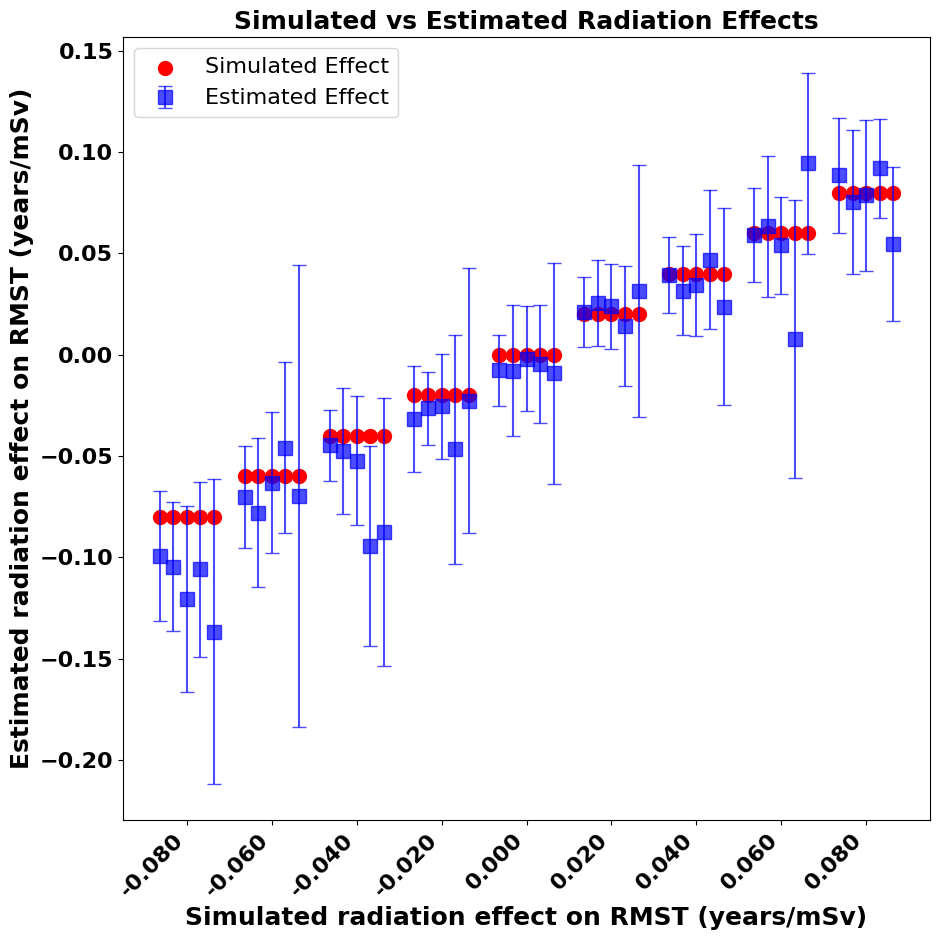

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results
df = pd.read_csv("simulation_results.csv")

# Sort the dataframe for consistent ordering
df = df.sort_values(['fake_effect_val', 'censor_intercept'])

# Unique fake_effect_vals
effects = sorted(df['fake_effect_val'].unique())

# Number of subgroups (should be 5 for censor_intercepts [-1, -0.5, 0, 0.5, 1])
num_subgroups = len(df['censor_intercept'].unique())

# Plot settings
group_width = 0.8
sub_width = group_width / num_subgroups
fig, ax = plt.subplots(figsize=(9.5, 9.5))

# Flags for legend
added_true_label = False
added_est_label = False

# Group positions
group_positions = np.arange(len(effects))

for group_idx, effect in enumerate(effects):
    group_pos = group_positions[group_idx]
    sub_df = df[df['fake_effect_val'] == effect]
    
    for sub_idx, (_, row) in enumerate(sub_df.iterrows()):
        x_pos = group_pos + (sub_idx - num_subgroups / 2 + 0.5) * sub_width
        
        # Plot true effect as red dot
        if not added_true_label:
            ax.scatter(x_pos, effect, color='red', s=100, label='Simulated Effect')
            added_true_label = True
        else:
            ax.scatter(x_pos, effect, color='red', s=100)
        
        # Plot estimated effect as blue square with error bars and transparency
        y = row['feat(T)0_mean']
        ci_lower = row['feat(T)0_ci_lower']
        ci_upper = row['feat(T)0_ci_upper']
        yerr = [[y - ci_lower], [ci_upper - y]]
        
        if not added_est_label:
            ax.errorbar(x_pos, y, yerr=yerr, fmt='s', color='blue', capsize=5, markersize=10, alpha=0.7, label='Estimated Effect')
            added_est_label = True
        else:
            ax.errorbar(x_pos, y, yerr=yerr, fmt='s', color='blue', capsize=5, markersize=10, alpha=0.7)

# Set x-ticks and labels with larger bold font
ax.set_xticks(group_positions)
ax.set_xticklabels([f"{e:.3f}" for e in effects], rotation=45, ha='right', fontsize=16, fontweight='bold', color='black')

# Set axis labels with larger bold font
ax.set_xlabel('Simulated radiation effect on RMST (years/mSv)', fontsize=18, fontweight='bold', color='black')
ax.set_ylabel('Estimated radiation effect on RMST (years/mSv)', fontsize=18, fontweight='bold', color='black')

# Set title with larger bold font
ax.set_title('Simulated vs Estimated Radiation Effects', fontsize=18, fontweight='bold', color='black')

# Legend with larger font
ax.legend(fontsize=16)

# Set y-tick labels with larger bold font
ax.tick_params(axis='y', labelsize=16, colors='black')
for label in ax.get_yticklabels():
    label.set_fontweight('bold')

# Save the plot
plt.tight_layout()
plt.savefig("simulation_plot.png", dpi=600)
print("Plot saved to simulation_plot.png")